# Efficient Storage

In [ ]:
import os
import random
import pretty_midi

def get_random_midi_file(root_dir):
    midi_files = []
    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:

            if filename.endswith('.mid') or filename.endswith('.midi'):
                midi_files.append(os.path.join(dirpath, filename))
    
    if not midi_files:
        raise FileNotFoundError(f"No MIDI files found in {root_dir}")
    
    return random.choice(midi_files)

# Usage
root_directory = './lmd_full'
random_midi_file = get_random_midi_file(root_directory)
print(f"Random MIDI file: {random_midi_file}")

filename = random_midi_file

def get_random_pretty_midi_file():
    filename = get_random_midi_file(root_directory)
    return pretty_midi.PrettyMIDI(filename)

In [ ]:
import torch
def process_midi_data(midi_data):
    song = []
    time_per_quarter_note = midi_data.tick_to_time(midi_data.resolution)
    for i, instrument in enumerate(midi_data.instruments):
        for note in instrument.notes:
            track = i
            start = note.start
            duration = note.end - note.start
            pitch = note.pitch

            notedata = [track, start, duration, pitch]
            song.append(notedata)
        # sort by start time
        song.sort(key=lambda x: x[1])
        # prepend the time_per_quarter_note
    song.insert(0, [time_per_quarter_note, 0, 0, 0])
    return torch.tensor(song, dtype=torch.float32)

song_lengths = []
songs = []
for i in range(100):
    try:
        midi_data = get_random_pretty_midi_file()
    except Exception as e:
        print(f"Error reading file: {e}")
        continue

    song = process_midi_data(midi_data)
    songs.append(song)

def get_memory_used(tensor):
    return tensor.element_size() * tensor.nelement()

total_memory = 0
for song in songs:
    total_memory += get_memory_used(song)

print(f"Total memory used: {total_memory} bytes")
# in MB
print(f"Total memory used: {total_memory / 1024 / 1024} MB")

# Loading Data (old)

In [ ]:

        

def process_midi(filename, track_index=0):
    # Load the MIDI file
    midi_data = pretty_midi.PrettyMIDI(filename)

    # Print the TPQN (Ticks Per Quarter Note)
    print("TPQN:", midi_data.resolution)

    # Print the time per tick
    time_per_tick = midi_data.tick_to_time(1)
    print("Time per tick:", time_per_tick)

    # Get the specified track of the MIDI file
    track = midi_data.instruments[track_index]

    # Get all the "note on" messages in the track
    note_on_messages = [note for note in track.notes if note.velocity > 0]

    # Assuming 4/4 time signature
    ticks_per_measure = 4 * midi_data.resolution

    # Create a list to store the annotated notes
    annotated_notes = []

    # Iterate over each note on message
    for i, note in enumerate(note_on_messages):
        # Get the measure index of the note
        tick = midi_data.time_to_tick(note.start)
        measure_index = tick // ticks_per_measure

        # Get the ticks since the last measure for the note
        ticks_since_last_measure = tick % ticks_per_measure

        # Get the ticks since the last note
        if i > 0:
            ticks_since_last_note = tick - midi_data.time_to_tick(note_on_messages[i-1].start)
        else:
            ticks_since_last_note = tick

        # Create a dictionary to store the annotated note information
        annotated_note = {
            'note': note,
            'measure_index': measure_index,
            'ticks_since_last_measure': ticks_since_last_measure,
            'ticks_since_last_note': ticks_since_last_note
        }

        # Append the annotated note to the list
        annotated_notes.append(annotated_note)

    # Print the first 10 annotated notes
    # for i, annotated_note in enumerate(annotated_notes[:10]):
    #     print("Note:", annotated_note['note'])
    #     print("Measure Index:", annotated_note['measure_index'])
    #     print("Ticks since last measure:", annotated_note['ticks_since_last_measure'])
    #     print("Ticks since last note:", annotated_note['ticks_since_last_note'])
    #     print("---")

    return annotated_notes

# Usage
filename = random_midi_file
track_index = 0

annotated_notes = process_midi(filename, track_index)
print(len(annotated_notes))

In [ ]:
import torch
import pretty_midi

# class for a song

class Song:
    def __init__(self, filename):
        midi_data = pretty_midi.PrettyMIDI(filename)
        self.time_per_measure = midi_data.tick_to_time(midi_data.resolution * 4)
        self.tracks = []
        for track in midi_data.instruments:
            track_data = []
            for note in track.notes:
                start_tick = note.start
                pitch = note.pitch
                track_data.append([start_tick, pitch])
            # add the track data to the list of tracks in a torch tensor
            self.tracks.append(torch.tensor(track_data, dtype=torch.float32))

In [ ]:
def process_midi_file(filename):
    try:
        song = Song(filename)
        return song, None
    except Exception as e:
        return None, e

def collect_midi_files(root_directory):
    midi_files = []
    for dirpath, _, filenames in os.walk(root_directory):
        for filename in filenames:
            if filename.endswith('.mid') or filename.endswith('.midi'):
                midi_files.append(os.path.join(dirpath, filename))
    return midi_files

if __name__ == "__main__":
    root_directory = './lmd_full'
    midi_files = collect_midi_files(root_directory)

    songs = []
    errors_processing = 0

    with Pool(cpu_count()) as pool:
        results = list(tqdm(pool.imap(process_midi_file, midi_files), total=len(midi_files)))

    for song, error in results:
        if song:
            songs.append(song)
        if error:
            errors_processing += 1

    print(f"Errors processing: {errors_processing}")


In [ ]:
import pretty_midi
import os
root_directory = './lmd_full'
midi_files = []
for dirpath, _, filenames in os.walk(root_directory):
    for filename in filenames:

        if filename.endswith('.mid') or filename.endswith('.midi'):
            midi_files.append(
                os.path.join(dirpath, filename)
            )

songs_to_count = 100
print(f"Total number of MIDI files: {len(midi_files)}")
errors_processing = 0
total_number_of_notes = 0
for i, midi_data in enumerate(midi_files):
    try:
        # get the total number of notes
        notes_per_song = 0
        midi_file = pretty_midi.PrettyMIDI(midi_data)
        for track in midi_file.instruments:
            notes_per_song += len(track.notes)
        # print(f"notes per song: {notes_per_song}")
        total_number_of_notes += notes_per_song
    except Exception as e:
        print(e)
        errors_processing += 1
    if i > songs_to_count:
        break

    
print(f"Total number of notes: {total_number_of_notes}")
notes_per_file = total_number_of_notes / songs_to_count
print(f"notes per file: {notes_per_file}")

In [ ]:
from tqdm import tqdm

songs = []
errors_processing = 0
for midi_data in tqdm(midi_files):
    try:
        song = Song(midi_data)
        songs.append(song)
    except Exception as e:
        errors_processing += 1

In [ ]:


class SongData(Dataset):
    def __init__(self, songs):
        self.songs = songs
        self.global_track_id_to_song_id = []
        for i, song in enumerate(songs):
            for track in song.instruments:
                self.global_track_id_to_song_id.append(i)

    def __len__(self):
        return len(self.global_track_id_to_song_id)

    def __getitem__(self, instance_idx):  
        song_idx = self.global_track_id_to_song_id[instance_idx]
        song = self.songs[song_idx]
        track_idx = instance_idx - song_idx
        sample = {'data': self.data[idx], 'label': self.labels[idx]}
        return sample

# Generate some random data
data = torch.randn(100, 3, 32, 32)  # 100 samples, 3 channels, 32x32 images
labels = torch.randint(0, 10, (100,))  # 100 labels for 10 classes

# Create dataset and dataloader
dataset = MyDataset(data, labels)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)

# Iterate through the dataloader
for batch in dataloader:
    data_batch = batch['data']
    labels_batch = batch['label']
    print(data_batch.shape, labels_batch.shape)
    # Add your training code here



In [ ]:
import sys
from collections import deque

def get_recursive_size(obj, seen=None):
    """Recursively finds the total memory usage of an object."""
    if seen is None:
        seen = set()
    
    obj_id = id(obj)
    
    if obj_id in seen:
        return 0
    
    seen.add(obj_id)
    
    size = sys.getsizeof(obj)
    
    if isinstance(obj, dict):
        size += sum(get_recursive_size(v, seen) for v in obj.values())
        size += sum(get_recursive_size(k, seen) for k in obj.keys())
    elif hasattr(obj, '__dict__'):
        size += get_recursive_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum(get_recursive_size(i, seen) for i in obj)
    
    return size

# Example usage
example_object = [1, 2, {3: "a", 4: ["b", "c"]}]
object_1 = [([1.1]*500) for _ in range(1000)]
object_2 = [torch.tensor([1.1]*500) for _ in range(1000)]

print("python")
print(get_recursive_size(object_1))
print("tensors")
print(get_recursive_size(object_2))

# # get the number of instruments
# midi_data.instruments


# Preprocessing All Data into sequences

In [ ]:
# Get a list of all the filenames
import os
import random
import pretty_midi

def get_all_filenames(root_dir):
    midi_files = []
    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:

            if filename.endswith('.mid') or filename.endswith('.midi'):
                midi_files.append(os.path.join(dirpath, filename))
    
    if not midi_files:
        raise FileNotFoundError(f"No MIDI files found in {root_dir}")
    return midi_files

# Usage
root_directory = './lmd_full'
files = get_all_filenames(root_directory)

In [ ]:
import torch
import pretty_midi
def process_midi_data(midi_filename):
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_filename)
    except Exception as e:
        return None, e
    song = []
    time_per_quarter_note = midi_data.tick_to_time(midi_data.resolution)
    for i, instrument in enumerate(midi_data.instruments):
        for note in instrument.notes:
            track = i
            start = note.start
            duration = note.end - note.start
            pitch = note.pitch

            notedata = [track, start, duration, pitch]
            song.append(notedata)
        # sort by start time
        song.sort(key=lambda x: x[1])
        # prepend the time_per_quarter_note
    song.insert(0, [time_per_quarter_note, 0, 0, 0])
    return torch.tensor(song, dtype=torch.float32), None

# Usage
filename = random.choice(files)
song, error = process_midi_data(filename)
print(f"Filename: {filename}")

# the reuslting format:
# header: [time_per_quarter_note, 0, 0, 0]
# each note: [track, start, duration, pitch]

print(f"first note:")
print(f"track: {song[1][0]}")
print(f"start: {song[1][1]}")
print(f"duration: {song[1][2]}")
print(f"pitch: {song[1][3]}")

print(f"\nsecond note:")
print(f"track: {song[2][0]}")
print(f"start: {song[2][1]}")
print(f"duration: {song[2][2]}")
print(f"pitch: {song[2][3]}")


In [ ]:
# simple example of loading all the files (single process)
errors = []
songs = []
totalsongs = len(files)
for i, file in enumerate(files):
    if i % 1000 == 0:
        print(f"{i/totalsongs:.2f}% complete ({i})")
    try:
        song, error = process_midi_data(file)
        if error is not None:
            errors.append(error)
            continue
        songs.append(song)
    except Exception as e:
        print(f"unusual error: {e}")
    # if i > 100:
    #     break

In [ ]:
# Number of groups to split into
num_groups = 10

# Calculate the size of each group
group_size = len(songs) // num_groups

# Save each group directly
for i in range(num_groups):
    start_idx = i * group_size
    end_idx = (i + 1) * group_size if i < num_groups - 1 else len(songs)
    torch.save(songs[start_idx:end_idx], f'./dataset/song_group_{i}.pth')

# Handle any remaining tensors if the list size isn't perfectly divisible
if len(songs) % num_groups != 0:
    torch.save(songs[num_groups * group_size:], f'./dataset/song_group_{num_groups - 1}.pth')

# Training Hacking

## Building SongDataset

In [ ]:
# import torch

# loading all the data
# loaded_song_groups = []
# for i in range(num_groups):
#     loaded_song_groups.append(torch.load(f'./dataset/song_group_{i}.pth'))

# # Optionally, you can concatenate all groups back into a single list if needed
# loaded_songs = [song for group in loaded_song_groups for song in group]


In [ ]:
import torch
# set default device to cuda, raise an error if cuda is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
if not torch.cuda.is_available():
    raise ValueError("CUDA is not available. Please install a CUDA-enabled version of PyTorch.")
torch.set_default_device(device)

# Load the first group of tensors and move it to the GPU
first_group = torch.load('./dataset/song_group_0.pth', map_location=device)


In [ ]:
# the reuslting format:
# header: [time_per_quarter_note, 0, 0, 0]
# each note: [track, start, duration, pitch]

print(first_group[4])
print(first_group[4].device)

this is how the dataset building would work on a mock dataset

In [ ]:
test_context_length = 3

a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
b = [11, 12, 13, 14, 15, 16, 17, 18]

dataset = [a, b]

# desired datastructure:
# index 1: song [0], notes 0-2
# index 2: song [0], notes 2-4
# index 3: song [0], notes 4-6
# index 4: song [0], notes 6-8
# index 5: song [0], notes 8-9
# index 6: song [1], notes 0-2
# ...

# stored in the format: [song_index, note_start_index]

# Create the dataset
train_idxs = []
for i, song in enumerate(dataset):
    for j in range(0, len(song), test_context_length):
        train_idxs.append([i, j])



test_context_length = 3

a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
b = [11, 12, 13, 14, 15, 16, 17, 18]

dataset = [a, b]

# desired datastructure:
# index 1: song [0], notes 0-2
# index 2: song [0], notes 2-4
# index 3: song [0], notes 4-6
# index 4: song [0], notes 6-8
# index 5: song [0], notes 8-9
# index 6: song [1], notes 0-2
# ...

# stored in the format: [song_index, note_start_index]

# Create the dataset
data = []
for i, song in enumerate(dataset):
    for j in range(len(song) - test_context_length):
        if j % test_context_length == 0:
            data.append([i, j])


def build_idxs(dataset, context_length, ignore_header=True):
    idxs = []
    if ignore_header:
        start_idx = 1
    else:
        start_idx = 0
    for i, song in enumerate(dataset):
        for j in range(start_idx, len(song) - context_length, context_length):
            idxs.append([i, j])
    return idxs

# Usage
test_context_length = 3
dataset = [a, b]
train_idxs = build_idxs(dataset, test_context_length)

song, note_start = train_idxs[0]
dataset[song][note_start:note_start + test_context_length]

In [ ]:
# dataset is the first_group, but remove the first element of each song
# first element is the header
# each song is a tensor
dataset = []
for song in first_group:
    dataset.append(song)


context_length = 128

dataset_idxs = build_idxs(dataset, context_length)

song, note_start = dataset_idxs[1]

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class SongDataSet(Dataset):
    def __init__(self, songs, context_length=128, quantize_divisor=64):
        self.songs = songs
        self.dataset_idxs = build_idxs(songs, context_length)
        self.quantize_divisor = quantize_divisor
        self.perturbation_std = 0.05
        self.context_length = context_length
    

    def __len__(self):
        return len(self.dataset_idxs)

    def __getitem__(self, idx, different_perturbation_std=False):
        song_idx, note_start_idx = self.dataset_idxs[idx]
        song = self.songs[song_idx]
        notes = song[note_start_idx:note_start_idx + context_length]
        # Note format: [track, start, duration, pitch]

        time_per_quarter_note = song[0][0] # header, first element
        time_per_tick = (time_per_quarter_note * 4 / self.quantize_divisor).item() # quantize_divisor is ticks per measure

        perturbed_notes = notes.clone()
        # add gausian perturbations to start and duration, note index 1 and 2
        # return torch.normal(0, self.perturbation_std, perturbed_notes[:, 1].shape).shape
        perturbation_std = self.perturbation_std
        if different_perturbation_std is not False:
            perturbation_std = different_perturbation_std

        perturbed_notes[:, 1] += torch.normal(0, perturbation_std, perturbed_notes[:, 1].shape, device=device)
        perturbed_notes[:, 2] += torch.normal(0, perturbation_std, perturbed_notes[:, 2].shape, device=device)

        
        
        perturbed_notes_quantized = self.quantize_notes(perturbed_notes, time_per_tick)

        notes_quantized = self.quantize_notes(notes, time_per_tick)

        return {"notes": notes_quantized, "perturbed_notes": perturbed_notes_quantized, "time_per_tick": time_per_tick}
        


    def quantize_notes(self, notes, time_per_tick):
        # subtract the start time of the note with the smallest start time from all notes (zero-based start times, even if first is negative or positive)
        min_start_time = notes[:, 1].min()
        notes[:, 1] -= min_start_time

        quantized_notes = []
        for note in notes:
            quantized_note = self.quantize_note(note, time_per_tick)
            quantized_notes.append(quantized_note) # quantizes to about 3/100 of a second (depending on the song's time signature)
        
        while len(quantized_notes) < self.context_length:
            quantized_notes.append(torch.tensor([99999, 99999, 99999, 99999, 99999], dtype=torch.int64))
        return torch.stack(quantized_notes)
    
        

    def quantize_note(self, note, time_per_tick):
        track, start, duration, pitch = note

        track = track.item()
        start = start.item()
        duration = duration.item()
        pitch = pitch.item()

        start = round(start / time_per_tick)
        duration = round(duration / time_per_tick)

        measure = start // self.quantize_divisor
        measuretick = start % self.quantize_divisor

        # get the modulo of the measure so it doesn't exceed 32
        measure = measure % 32
        track = track % 32
        duration = max(min(duration, 127), 0) # bind duration index between 0 and 127
        pitch = max(min(pitch, 127), 0) # bind pitch index between 0 and 127

        # track: 0-31
        # measure: 0-31
        # measuretick: 0-63
        # duration: 0-128
        # pitch: 0-127
        return torch.tensor([track, measure, measuretick, duration, pitch], dtype=torch.int64)

song_dataset = SongDataSet(dataset, context_length=context_length)


In [ ]:

song_dataset[0]

## My Format Analysis and Music Demo

In [ ]:
maximum_measure_indexes = []

for i in range(10000):
    songsection = song_dataset[i]['notes']
    maximum_measure_indexes.append(songsection[:, 1].max().item())

print("done with the loop")
# for song in song_dataset.songs:
#     maximum_time_indexes.append(song[:, 1].max())

# plot the histogram
import matplotlib.pyplot as plt
plt.hist(maximum_measure_indexes, bins=32)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

def plot_track(song_tensor, track_number):
    """
    Plots the notes of a specific track from a song tensor.

    Paramet        # track: 0-31
        # measure: 0-31
        # measuretick: 0-63
        # duration: 0-128
        # pitch: 0-127
        return torch.tensor([track, measure, measuretick, duration, pitch], dtype=torch.int32)ers:
    - song_tensor: torch.Tensor, the quantized notes tensor of the song.
    - track_number: int, the track number to plot.
    """
    # Filter notes for the specified track
    track_notes = song_tensor[song_tensor[:, 0] == track_number]

    if track_notes.size(0) == 0:
        print(f"No notes found for track {track_number}")
        return

    # Extract start times, durations, and pitches
    start_times = track_notes[:, 1].numpy()
    durations = track_notes[:, 2].numpy()
    pitches = track_notes[:, 3].numpy()

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot each note as a horizontal bar
    for start, duration, pitch in zip(start_times, durations, pitches):
        ax.broken_barh([(start, duration)], (pitch - 0.4, 0.8), facecolors='blue')

    # Set labels and title
    ax.set_xlabel('Time (quantized ticks)')
    ax.set_ylabel('Pitch')
    ax.set_title(f'Track {track_number} Notes')

    # Show grid
    ax.grid(True)

    # Show the plot
    plt.show()

# Example usage
# Assuming song_dataset is an instance of SongDataSet and song_tensor is a tensor from the dataset
song_tensor = song_dataset[1]  # Get the first song tensor
plot_track(song_tensor, track_number=0)  # Plot the first track

In [ ]:
import matplotlib.pyplot as plt

def plot_all_tracks(song_tensor):
    """
    Plots the notes of all tracks from a song tensor, each in its own subplot.

    Parameters:
    - song_tensor: torch.Tensor, the quantized notes tensor of the song.
    """
    # Get unique track numbers
    track_numbers = song_tensor[:, 0].unique().numpy()

    # Create a figure with subplots
    fig, axes = plt.subplots(len(track_numbers), 1, figsize=(10, 5 * len(track_numbers)), sharex=True)

    if len(track_numbers) == 1:
        axes = [axes]  # Ensure axes is iterable if there's only one track

    # Plot each track
    for ax, track_number in zip(axes, track_numbers):
        # Filter notes for the current track
        track_notes = song_tensor[song_tensor[:, 0] == track_number]

        if track_notes.size(0) == 0:
            continue

        # Extract start times, durations, and pitches
        start_times = track_notes[:, 1].numpy()
        durations = track_notes[:, 2].numpy()
        pitches = track_notes[:, 3].numpy()

        # Plot each note as a horizontal bar
        for start, duration, pitch in zip(start_times, durations, pitches):
            ax.broken_barh([(start, duration)], (pitch - 0.4, 0.8), facecolors='blue')

        # Set labels and title
        ax.set_ylabel('Pitch')
        ax.set_title(f'Track {track_number} Notes')
        ax.grid(True)

    # Set common x-label
    axes[-1].set_xlabel('Time (quantized ticks)')

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming song_dataset is an instance of SongDataSet and song_tensor is a tensor from the dataset
song_tensor = song_dataset[1]  # Get the first song tensor
plot_all_tracks(song_tensor)  # Plot all tracks

In [ ]:
import pretty_midi
import torch

def tensor_to_midi(tensor, output_filename, time_per_tick):
    """
    Converts a tensor representation of a song back to a MIDI file.

    Parameters:
    - tensor: torch.Tensor, the quantized notes tensor of the song.
    - output_filename: str, the filename for the output MIDI file.
    """
    # Create a PrettyMIDI object
    midi = pretty_midi.PrettyMIDI()

    # Get unique track numbers
    track_numbers = tensor[:, 0].unique().numpy()

    for track_number in track_numbers:
        # Create an Instrument instance for each track
        instrument = pretty_midi.Instrument(program=0)  # Default to Acoustic Grand Piano

        # Filter notes for the current track
        track_notes = tensor[tensor[:, 0] == track_number]

        # Extract start times, durations, and pitches
        start_times = track_notes[:, 1].numpy()
        durations = track_notes[:, 2].numpy()
        pitches = track_notes[:, 3].numpy()

        # Create Note objects and add them to the instrument
        for start, duration, pitch in zip(start_times, durations, pitches):
            note = pretty_midi.Note(
                velocity=100,  # Default velocity
                pitch=int(pitch),
                start=(start*time_per_tick).item(),
                end=((start + duration)*time_per_tick).item()
            )
            instrument.notes.append(note)

        # Add the instrument to the PrettyMIDI object
        midi.instruments.append(instrument)

    # Write out the MIDI data
    midi.write(output_filename)

# Example usage




song_example = song_dataset[1]  # Get the first song tensor
notes = song_example["notes"]
perturbed_notes = song_example["perturbed_notes"]
time_per_tick = song_example["time_per_tick"]

tensor_to_midi(perturbed_notes, 'output_song.mid', time_per_tick)

In [ ]:
import pygame

def play_midi_file(midi_filename):
    """
    Plays a MIDI file using pygame.

    Parameters:
    - midi_filename: str, the filename of the MIDI file to play.
    """
    # Initialize pygame
    pygame.init()

    # Set up the mixer to play MIDI
    pygame.mixer.init()
    pygame.mixer.music.load(midi_filename)

    # Play the MIDI file
    pygame.mixer.music.play()

    # Keep the program running until the music stops
    while pygame.mixer.music.get_busy():
        pygame.time.Clock().tick(10)

# Example usage
midi_filename = 'output_song.mid'
play_midi_file(midi_filename)

## Building the Model

In [ ]:
import os 

# device= 'cuda' if torch.cuda.is_available() else 'cpu'
# torch.set_default_device(device)
# assert device == 'cuda', "This notebook is not optimized for CPU"

config = {
    "learning_rate": 1e-3,
    "eval_interval": 500,
    "max_iters": 3000, 
    "num_epochs": 2,
    "H": 16,
    "B": 64,
    "T": 128,
    "C": 128,
    "pitches": 128,
    "feedforward_factor": 3,
    "n_heads": 6,
    "dropout": 0.4,
    "l2_penalty": 0.0,
    "n_layers": 6,
    "tokenizer_vocab_size": 4096,
    "git_hash": os.popen("git rev-parse HEAD").read().strip(),
    "a": 8,
    "b": 32,
    "c": 32,
    "d": 16,
    "e": 32,
    "f": 8
}

# initial
for k,v in config.items():
    locals ()[k] = v

### Model Components

In [ ]:

import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)


class Head(nn.Module):
    '''One Head of self-attention'''
    def __init__(self, H, cross_attention=False):
        super().__init__()
        self.cross_attention = cross_attention
        self.query = nn.Linear(C, H, bias=False)
        self.key = nn.Linear(C, H, bias=False)
        self.value = nn.Linear(C, H, bias=False)
        # self.output = nn.Linear(H, C, bias=False) # output matrix
        self.register_buffer('tril', torch.tril(torch.ones(T, T)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, cross_attention_sequence=None):
        # Query and Key matrices for the attention mechanism
        # x: 8 tokens
        # Q: 16 tall (arbitrary), 32 long channels
        # K: 16 tall (arbitrary), 32 long channels

        query_vectors = self.query(x)

        if self.cross_attention == True:
            key_vectors = self.key(cross_attention_sequence)
            assert key_vectors.shape[-2] == T, "cross_attention_sequence must be the same length as the input sequence"
        else:
            key_vectors = self.key(x)


        # Attention masking(so we can't look into the past):

        if self.cross_attention == False:
            tril = self.tril
            wei = torch.zeros(T, T) 
            wei = wei.masked_fill(tril == 0, float('-inf')) # set the upper triangular to -inf

        # multiply the two to get the attention weights
        attention_pattern = query_vectors @ key_vectors.transpose(-2, -1) # T, T
        attention_pattern = attention_pattern / (H ** 0.5) # scale the attention pattern for numerical stability

        if self.cross_attention == False: # we are doing self-attention, causal masking
            attention_weights = F.softmax(attention_pattern + wei, dim=-1) # T, T (the row dimension is the query)
        else:
            # we are doing cross attention, so we don't need to mask the attention weights
            attention_weights = F.softmax(attention_pattern, dim=-1)

        attention_weights = self.dropout(attention_weights)

        value_vectors = self.value(x) # the direction we should go in the embedding space for each token (ie more blue) T, H

        # apply the attention weights to the value vectors
        context = attention_weights @ value_vectors # T, H

        # project back into original space from value space
        # return self.output(context)
        return context

# x = torch.randn(B,T,C)
# x = torch.randn(T,C)
# head_self_attention = Head(H, cross_attention=False)

# print(head_cross_attention(x, x))
# print("="*40)
# print(head_self_attention(x))




In [ ]:
class MultiHeadAttention(nn.Module):
    '''Multiple heads of self-attention or cross-attention'''
    def __init__(self, H, C, n_heads, cross_attention=False): # H is head embedding space size, n_heads is number of heads, cross_attention flag
        super().__init__()
        self.heads = nn.ModuleList([Head(H, cross_attention=cross_attention) for _ in range(n_heads)])
        self.combine_heads = nn.Linear(H*n_heads, C)
        self.dropout = nn.Dropout(dropout)
        self.cross_attention = cross_attention

    def forward(self, x, cross_attention_sequence=None):
        if self.cross_attention and cross_attention_sequence is not None:
            x = torch.cat([head(x, cross_attention_sequence) for head in self.heads], dim=-1)
        else:
            x = torch.cat([head(x) for head in self.heads], dim=-1)
        x = self.combine_heads(x)  # T, C
        return self.dropout(x)
    
x = torch.randn(T,C)
multi_head_attention = MultiHeadAttention(H, C, n_heads, cross_attention=True)
print(multi_head_attention(x, x))

In [ ]:
class FeedForward(nn.Module):
    '''Feed-forward neural network'''
    def __init__(self, C):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(C, C * feedforward_factor),
            nn.ReLU(),
            nn.Linear(C * feedforward_factor, C),
            # nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class LayerNorm(nn.Module):
    '''Layer normalization'''
    def __init__(self, C, use_affine=True):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(C)) if use_affine else None
        self.beta = nn.Parameter(torch.zeros(C)) if use_affine else None

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        if self.gamma is not None and self.beta is not None:
            return self.gamma * (x - mean) / (std + 1e-6) + self.beta
        else:
            return (x - mean) / (std + 1e-6)

In [ ]:
class EncoderBlock(nn.Module):
    '''Transformer encoder block'''
    def __init__(self, H, C, n_heads):
        super().__init__()
        self.attention = MultiHeadAttention(H, C, n_heads, cross_attention=True)
        self.norm1 = LayerNorm(C)
        self.feedforward = FeedForward(C)
        self.norm2 = LayerNorm(C)

    def forward(self, x):
        x = self.norm1(x + self.attention(x, x))
        x = self.norm2(x + self.feedforward(x))
        return x


x = torch.randn(T,C)

enc = EncoderBlock(H, C, n_heads)

print(enc(x).shape)
print(T,C)



In [ ]:
class DecoderBlock(nn.Module):
    '''Transformer decoder block'''
    def __init__(self, H, C, n_heads, feedforward_factor):
        super().__init__()
        self.self_attention = MultiHeadAttention(H, C, n_heads)
        self.cross_attention = MultiHeadAttention(H, C, n_heads, cross_attention=True)
        self.feedforward = FeedForward(C)
        self.norm1 = LayerNorm(C)
        self.norm2 = LayerNorm(C)
        self.norm3 = LayerNorm(C)

    def forward(self, x, cross_attention_sequence):
        x = x + self.self_attention(self.norm1(x))
        x = x + self.cross_attention(self.norm2(x), cross_attention_sequence)
        x = x + self.feedforward(self.norm3(x))
        return x
    
x = torch.randn(T,C)
cross_attention_sequence = torch.randn(T,C)

dec = DecoderBlock(H, C, n_heads, feedforward_factor)
dec(x, cross_attention_sequence).shape

In [ ]:
class Block(nn.Module):
    '''Transformer block'''
    def __init__(self, H, C, n_heads):
        super().__init__()
        self.attention = MultiHeadAttention(H, C, n_heads)
        self.ff = FeedForward(C)
        self.norm1 = LayerNorm(C, use_affine=True)
        self.norm2 = LayerNorm(C, use_affine=True)

    def forward(self, x):
        x = x + self.attention(self.norm1(x))
        x = x + self.ff(self.norm2(x))
        return x

timingtransformer

In [ ]:
class TimingTransformer(nn.Module):

    # track: 0-31
    # measure: 0-31
    # measuretick: 0-63
    # duration: 0-128
    # pitch: 0-127
    # return torch.tensor([track, measure, measuretick, duration, pitch], dtype=torch.int32)
    def __init__(self, n_layers):
        super().__init__()
        # embedding dimensions (go into model)
        assert a + b + c + d + e + f == C, f"embedding dimensions must sum to C:{C}"
        self.track_embedding_table = nn.Embedding(32, a) # one-hot vector of length 32 (because there are 32 possible tracks) -> a
        self.measure_embedding_table = nn.Embedding(32, b) # 32 possible measures, stored in b dimensions 32 -> b
        self.measuretick_embedding_table = nn.Embedding(64, c)
        self.duration_embedding_table = nn.Embedding(128, d)
        self.pitch_embedding_table = nn.Embedding(128, e)
        self.position_embedding_table = nn.Embedding(T, f) 



        # model
        self.encoderlayers = nn.ModuleList([EncoderBlock(H, C, n_heads) for _ in range(n_layers)])
        self.decoderlayers = nn.ModuleList([DecoderBlock(H, C, n_heads, feedforward_factor) for _ in range(n_layers)])

        # de-embedding dimensions (go out of model)
        # Output scheme: a:b track, b:c measure, c:d measuretick, d:e duration, e:f pitch, f:g position
        # it doesn't really matter because we just try and minimize log-likelyhood of the target for each token

        # first 8 dimensions are track, so we want to predict the next track, which is a distribution over the 32 tracks, so output is 32
        # 8 -> 32
        self.track_head = nn.Linear(a, 32)
        # next 32 dimensions are measure, so we want to predict the next measure, which is a distribution over the 32 measures, so output is 32
        # 32 -> 32
        self.measure_head = nn.Linear(b, 32)
        self.measuretick_head = nn.Linear(c, 64)
        self.duration_head = nn.Linear(d, 128)
        self.pitch_head = nn.Linear(e, 128)
        self.position_head = nn.Linear(f, T) # last f dimensions are position, so we want to predict the next position, which is a distribution over the T positions, so output is T



        # LEGACY GPT REFERENCE CODE
        # self.token_embedding_table = nn.Embedding(vocab_size, C) # REMOVE
        # self.position_embedding_table = nn.Embedding(T, C) # REMOVE

        # self.lm_head = nn.Linear(C, vocab_size) # REMOVE
        # self.layers = nn.ModuleList([Block(H, C, n_heads) for _ in range(n_layers)])
        # self.block = nn.ModuleList([Block(H, C, n_heads)])
    
    def encode(self, idx):
        B, T, C = idx.shape # idx is a list of the indices of the tokens, without batch it would be:
        # [track, measure, measuretick, duration, pitch], [track, measure, measuretick, duration, pitch], ...
        # Channel for a given token is whether we are looking at track, measure, measuretick, duration, or pitch

        tracks = idx[:, :, 0]
        measures = idx[:, :, 1]
        measureticks = idx[:, :, 2]
        durations = idx[:, :, 3]
        pitches = idx[:, :, 4]

        track_emb = self.track_embedding_table(tracks)
        measure_emb = self.measure_embedding_table(measures)
        measuretick_emb = self.measuretick_embedding_table(measureticks)
        duration_emb = self.duration_embedding_table(durations)
        pitch_emb = self.pitch_embedding_table(pitches)

        position_sequence = self.position_embedding_table(torch.arange(T)).unsqueeze(0) # list of position embeddings, with a batch dimension, but only 1 batch
        pos_emb = position_sequence.repeat(B, 1, 1) # repeat across the batch dimension

        assert track_emb.shape == (B, T, 8), f"track_emb shape is {track_emb.shape}"
        assert measure_emb.shape == (B, T, 32), f"measure_emb shape is {measure_emb.shape}"
        assert measuretick_emb.shape == (B, T, 32), f"measuretick_emb shape is {measuretick_emb.shape}"
        assert duration_emb.shape == (B, T, 16), f"duration_emb shape is {duration_emb.shape}"
        assert pitch_emb.shape == (B, T, 32), f"pitch_emb shape is {pitch_emb.shape}"
        assert pos_emb.shape == (B, T, 8), f"pos_emb shape is {pos_emb.shape}"


        return torch.cat((track_emb, measure_emb, measuretick_emb, duration_emb, pitch_emb, pos_emb), dim=-1)


    def decode(self, latent_dimension):
        a_start, a_end = 0, a
        b_start, b_end = a_end, a_end + b
        c_start, c_end = b_end, b_end + c
        d_start, d_end = c_end, c_end + d
        e_start, e_end = d_end, d_end + e
        f_start, f_end = e_end, e_end + f

        track_emb = latent_dimension[:,:,a_start:a_end]
        measure_emb = latent_dimension[:,:,b_start:b_end]
        measuretick_emb = latent_dimension[:,:,c_start:c_end]
        duration_emb = latent_dimension[:,:,d_start:d_end]
        pitch_emb = latent_dimension[:,:,e_start:e_end]

        # input representation: [track, measure, measuretick, duration, pitch, pos] (all idx's)

        track_dist = self.track_head(track_emb)
        measure_dist = self.measure_head(measure_emb)
        measuretick_dist = self.measuretick_head(measuretick_emb)
        duration_dist = self.duration_head(duration_emb)
        pitch_dist = self.pitch_head(pitch_emb)

        return track_dist, measure_dist, measuretick_dist, duration_dist, pitch_dist



    
    def forward(self, idx_dirty,  targets):
        # ---- old GPT forward for reference ----

        # B, T = idx.shape # idx is the indices of the tokens
        # token_emb = self.token_embedding_table(idx) # batch_dim, sequence_dim, embedding_dim
        # pos_emb = self.position_embedding_table(torch.arange(T))
        # x = token_emb + pos_emb # token identities and positions contained

        # for layer in self.layers:
        #     x = layer(x)

        # logits = self.lm_head(x) # batch_dim, sequence_dim, vocab_size. basically next-token output distribution

        # batch_dim, sequence_dim, embedding_dim = logits.size()

        # # loss = F.cross_entropy(logits, targets) this won't work because we need 1d logits and 1d targets
        # # one-hot-vectors are a line in the x-dimension, so the shape of shape of the logits should be (-1, vocab_size).

        # if targets is None:
        #     return logits, None
        # else:
        #     # a list of all the predictions, reguardles of batch.
        #     # xdim: probabilities of each character in the vocab (embedding_dim=vocab_size)
        #     # ydim: all predictions for all batches and sequences flattened (batch_dim*sequence_dim)
        #     logits_loss_view = logits.view(-1, vocab_size) 
        #     # targets loss view
        #     # xdim: all targets for all batches flattened (batch_dim*sequence_dim)
        #     # so this would be like, [1,4,5,1,2,3, ...]
        #     # where each number is the correct next index of the one hot vector
        #     targets_loss_view = targets.view(-1)
        #     loss = F.cross_entropy(logits_loss_view, targets_loss_view)
        #     return logits, loss
        # ---- end old GPT forward for reference ----
        


        # idx shape: Batch, Time, [track, measure, measuretick, duration, pitch]
        # idx shape: Batch, Time, Channel
        b, t, c = idx_dirty.shape

        encoder_sequence = self.encode(idx_dirty)

        decoder_sequence = self.encode(targets) # during train, targets=correct notes, during test targets=autoregressive_sequence


        for encoderlayer in self.encoderlayers:
            encoder_sequence = encoderlayer(encoder_sequence)

        for decoderlayer in self.decoderlayers:
            decoder_sequence = decoderlayer(decoder_sequence, encoder_sequence)

        # decode the output
        track_dist, measure_dist, measuretick_dist, duration_dist, pitch_dist = self.decode(decoder_sequence)

        track_targets = targets[:, :, 0]
        measure_targets = targets[:, :, 1]
        measuretick_targets = targets[:, :, 2]
        duration_targets = targets[:, :, 3]
        pitch_targets = targets[:, :, 4]


        track_loss = F.cross_entropy(track_dist.view(b*t, 32), track_targets.view(b*t))
        measure_loss = F.cross_entropy(measure_dist.view(b*t, 32), measure_targets.view(b*t))
        measuretick_loss = F.cross_entropy(measuretick_dist.view(b*t, 64), measuretick_targets.view(b*t))
        duration_loss = F.cross_entropy(duration_dist.view(b*t, 128), duration_targets.view(b*t))
        pitch_loss = F.cross_entropy(pitch_dist.view(b*t, 128), pitch_targets.view(b*t))

        total_loss = track_loss + measure_loss + measuretick_loss + duration_loss + pitch_loss



        return track_dist, measure_dist, measuretick_dist, duration_dist, pitch_dist, total_loss




    def generate(self,  full_sequence, denoised_sequence, temperature=1.0):
        # full sequence has batch dimension + padding, denoised sequence has no batch or padding

        def predict_next_token(full_sequence, denoised_sequence):

            # predict the next element in denoised_sequence
            # full_sequence: the full sequence of tokens (noisy)
            # denoised_sequence: the denoised sequence of tokens (no batch dimension, just the sequence)
            denoised_sequence_length = denoised_sequence.shape[0]
            last_token_idx = denoised_sequence_length - 1
            # pad the denoised sequence to the full sequence length with tokens of [99999, 99999, 99999, 99999, 99999]
            denoised_sequence_padded = torch.cat((denoised_sequence, torch.ones(1, T - denoised_sequence_length, 5, dtype=torch.int64) * 99999), dim=1)
            # add batch dimension
            # denoised_sequence_padded = denoised_sequence_padded.unsqueeze(0)

            track_dist, measure_dist, measuretick_dist, duration_dist, pitch_dist = self(full_sequence, decoder_autoregressive_input=denoised_sequence_padded)
            return
            # get only the first batch, so we don't deal with the batch dimension
            track_dist = track_dist[0] # shape: [T, 32] (32 possible tracks)
            measure_dist = measure_dist[0] # shape: [T, 32] (32 possible measures)
            measuretick_dist = measuretick_dist[0] # shape: [T, 64] (64 possible measureticks)
            duration_dist = duration_dist[0] # shape: [T, 128] (128 possible durations)
            pitch_dist = pitch_dist[0] # shape: [T, 128] (128 possible pitches)

            # get the predictions of the last token
            last_note_track_logits = track_dist[last_token_idx]
            last_note_measure_logits = measure_dist[last_token_idx]
            last_note_measuretick_logits = measuretick_dist[last_token_idx]
            last_note_duration_logits = duration_dist[last_token_idx]
            last_note_pitch_logits = pitch_dist[last_token_idx]

            # get the most likely track, measure, etc.
            next_track = torch.argmax(last_note_track_logits)
            next_measure = torch.argmax(last_note_measure_logits)
            next_measuretick = torch.argmax(last_note_measuretick_logits)
            next_duration = torch.argmax(last_note_duration_logits)
            next_pitch = torch.argmax(last_note_pitch_logits)

            next_token =  torch.tensor([next_track, next_measure, next_measuretick, next_duration, next_pitch])
            return next_token
        
        next_token = predict_next_token(full_sequence, denoised_sequence)
        return next_token


        # for _ in range(max_new_tokens):
        #     logits, loss = self(idx[:,-T:])
        #     # get the predictions of the last token
        #     last_token_logits = logits[:, -1, :] / temperature # all batches, last token, all probabilities
        #     # softmax to get probabilities
        #     probabilities = F.softmax(last_token_logits, dim=-1)
        #     # sample from the probabilities
        #     next_token = torch.multinomial(probabilities, num_samples=1)
        #     # add the new token to the idx tensor
        #     idx = torch.cat((idx, next_token), dim=1)
        # return idx
    


xb = torch.randint(0, 8, (B, T, 5))
yb = torch.randint(0, 8, (B, T, 5))

model = TimingTransformer(n_layers)


# logits, loss = model(xb, yb)
track_dist, measure_dist, measuretick_dist, duration_dist, pitch_dist, loss = model.forward(xb, targets=yb)
print(f"track dist shape: {track_dist.shape}")
print(f"measure dist shape: {measure_dist.shape}")
print(f"measuretick dist shape: {measuretick_dist.shape}")
print(f"duration dist shape: {duration_dist.shape}")
print(f"pitch dist shape: {pitch_dist.shape}")
print(f"loss: {loss}")




# test_idx = torch.zeros(1, T).long()
# model.forward(idx=test_idx)
# decode(model.generate(idx=test_idx, max_new_tokens=100)[0].tolist())

In [ ]:
print(a,b,c,d,e,f)

In [ ]:
# ensure we are running on cuda
print(model.track_head.weight.device)

In [ ]:
# get the total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

# Training

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Old loop
# eval_iters = 10
# eval_interval = 300
# @torch.no_grad()
# def estimate_loss(is_last=False):
#     out = {}
#     model.eval()
#     for split in ['train', 'val']:
#         real_iters = eval_iters
#         if is_last and split == 'val':  # increase last eval to mitigate noise
#             real_iters *= 10 
#         losses = torch.zeros(real_iters)
#         for k in range(real_iters):
#             X, Y = get_batch(split)
#             logits, loss = model(X, Y)
#             losses[k] = loss.item()
#         out[split] = losses.mean() / chars_per_token
#     model.train()
#     return out
    

In [ ]:
output = torch.softmax(torch.tensor([[0, 2, 0], [0,0,2]], dtype=torch.float), dim=1)
print(output)
labels = torch.tensor([1, 2], dtype=torch.int64)
F.cross_entropy(output, labels)

In [ ]:
# Example forward pass using the dataset
notes = song_dataset[3]["notes"]
print(f"original")
print(notes[1])

notes_perturbed = song_dataset[3]["perturbed_notes"]
print(f"perturbed")
print(notes_perturbed[1])

notes_batched = notes.unsqueeze(0)
notes_perturbed_batched = notes_perturbed.unsqueeze(0)
print(model(notes_batched, targets=notes_perturbed_batched))

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

# assuming `song_dataset` is already created
generator = torch.Generator(device=device)

# Define the split ratio
train_ratio = 0.9
train_size = int(train_ratio * len(song_dataset))
val_size = len(song_dataset) - train_size

# split the dataset
train_dataset, val_dataset = random_split(song_dataset, [train_size, val_size], generator=generator)
batch_size=B

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, generator=generator)



In [ ]:
@torch.no_grad()
def estimate_loss(num_samples=None):
    model.eval()
    losses = {'train': 0, 'val': 0}
    for split, dataloader in [('train', train_dataloader), ('val', val_dataloader)]:
        total_loss = 0
        num_batches = len(dataloader)
        
        if num_samples is not None:
            num_batches = max(min(num_batches, num_samples // dataloader.batch_size), 1)
        
        for i, batch in enumerate(dataloader):
            if num_samples is not None and i >= num_batches:
                break
            inputs = batch['notes']
            targets = batch['perturbed_notes']
            _, _, _, _, _, loss = model(inputs, targets=targets)
            total_loss += loss.item()
        
        avg_loss = total_loss / num_batches
        losses[split] = avg_loss
    model.train()
    return losses

In [ ]:
estimate_loss(num_samples = 50)

In [ ]:
# set the model to training mode
model.train()

# define the number of epochs for training
num_epochs = config['num_epochs']
eval_interval = config['eval_interval']

# training loop
for epoch in range(num_epochs):
    total_loss = 0
    for i, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        inputs = batch['notes']
        targets = batch['perturbed_notes']  # or whatever your target is

        # zero the gradients
        optimizer.zero_grad()

        # forward pass: compute the model output
        _, _, _, _, _, loss = model(inputs, targets)

        # backward pass: compute the gradient of the loss with respect to model parameters
        loss.backward()

        # update the model parameters
        optimizer.step()

        # accumulate the loss
        total_loss += loss.item()
        if i % eval_interval == 0 and i > 0:
            eval_loss = estimate_loss(num_samples=50)
            print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {eval_loss['val']}, Training Loss: {eval_loss['train']}")

    # compute the average loss for the epoch
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_loss}")


# save the model after training
torch.save(model.state_dict(), 'model.pth')


Training profiling
```
Epoch 1/4:   1%|          | 200/16315 [01:10<1:34:04,  2.85it/s]
Average Data loading time: 0.0000s
Average Forward pass time: 0.0143s
Average Backward pass time: 0.0194s
Average Gradient update time: 0.0105s
```

# Evaluation

In [ ]:

print(device)
torch.set_default_device(device)
# load model.pth
model.load_state_dict(torch.load('model.pth', map_location=device))

# Move the model to the GPU
model.to(device)
model.eval()

print(model.track_embedding_table.weight.device)

In [ ]:
# set default device to cuda
# NOTE TO SELF: Load the song_dataset above before running this code
# first_song = song_dataset[0]

# # get the notes tensor
# notes = first_song['notes']
# perturbed_notes = first_song['perturbed_notes']


# perturbed_notes_batched = perturbed_notes.unsqueeze(0)
# denoised_sequence = torch.tensor([], dtype=torch.int64)
# # model.generate(perturbed_notes_batched, denoised_sequence)
# model(perturbed_notes_batched)



# Example forward pass using the dataset
# notes = song_dataset[3]["notes"].to(device)
# print(f"original")
# print(notes[1])

notes_perturbed = song_dataset[3]["perturbed_notes"]
# print(f"perturbed")
# print(notes_perturbed[1])

notes_batched = notes_perturbed.unsqueeze(0)
print(notes_batched.shape)

autoregressive_sequence = torch.tensor([], dtype=torch.int64, device=device)

# pad the autoregressive sequence to the full sequence length with tokens of [99999, 99999, 99999, 99999, 99999]
autoregressive_sequence_padded = torch.cat((autoregressive_sequence, torch.ones(1, T - autoregressive_sequence.shape[1], 5, dtype=torch.int64) * 99999), dim=1)

model(notes_batched)



In [ ]:

model(notes_batched, decoder_autoregressive_input=autoregressive_sequence)
pad_tensor = torch.tensor([[99999, 99999, 99999, 99999, 99999]], dtype=torch.int64)
real_tensor = torch.tensor([[1, 2, 3, 4, 5]], dtype=torch.int64)
while len(real_tensor) < 10:
    real_tensor = torch.cat((real_tensor, pad_tensor), dim=0)

print(real_tensor)

# Cleaned Code

dataloading

In [2]:
import torch
# set default device to cuda, raise an error if cuda is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
if not torch.cuda.is_available():
    raise ValueError("CUDA is not available. Please install a CUDA-enabled version of PyTorch.")
torch.set_default_device(device)

# Load the first group of tensors and move it to the GPU
first_group = torch.load('./dataset/song_group_0.pth', map_location=device)



def build_idxs(dataset, context_length, ignore_header=True):
    idxs = []
    if ignore_header:
        start_idx = 1
    else:
        start_idx = 0
    for i, song in enumerate(dataset):
        for j in range(start_idx, len(song) - context_length, context_length):
            idxs.append([i, j])
    return idxs





# dataset is the first_group, but remove the first element of each song
# first element is the header
# each song is a tensor
dataset = []
for song in first_group:
    dataset.append(song)


context_length = 128

dataset_idxs = build_idxs(dataset, context_length)

song, note_start = dataset_idxs[1]

import torch
from torch.utils.data import Dataset, DataLoader

class SongDataSet(Dataset):
    def __init__(self, songs, context_length=128, quantize_divisor=64):
        self.songs = songs
        self.dataset_idxs = build_idxs(songs, context_length)
        self.quantize_divisor = quantize_divisor
        self.perturbation_std = 0.05
        self.context_length = context_length
    

    def __len__(self):
        return len(self.dataset_idxs)

    def __getitem__(self, idx, different_perturbation_std=False):
        song_idx, note_start_idx = self.dataset_idxs[idx]
        song = self.songs[song_idx]
        notes = song[note_start_idx:note_start_idx + context_length]
        # Note format: [track, start, duration, pitch]

        time_per_quarter_note = song[0][0] # header, first element
        time_per_tick = (time_per_quarter_note * 4 / self.quantize_divisor).item() # quantize_divisor is ticks per measure

        perturbed_notes = notes.clone()
        # add gausian perturbations to start and duration, note index 1 and 2
        # return torch.normal(0, self.perturbation_std, perturbed_notes[:, 1].shape).shape
        perturbation_std = self.perturbation_std
        if different_perturbation_std is not False:
            perturbation_std = different_perturbation_std

        perturbed_notes[:, 1] += torch.normal(0, perturbation_std, perturbed_notes[:, 1].shape, device=device)
        perturbed_notes[:, 2] += torch.normal(0, perturbation_std, perturbed_notes[:, 2].shape, device=device)

        
        
        perturbed_notes_quantized = self.quantize_notes(perturbed_notes, time_per_tick)

        notes_quantized = self.quantize_notes(notes, time_per_tick)

        # autoregressive_sequence = [start token, note1, note2, ... , noteN]
        # labels = [note1, note2, ... , noteN, noteN+1]
        # start token is: [32, 32, 64, 128, 128]

        autoregressive_sequence = torch.cat((torch.tensor([[32, 32, 64, 128, 128]], dtype=torch.int64, device=device), notes_quantized[:-1]), dim=0)
        labels = notes_quantized



        return {"notes": notes_quantized, "perturbed_notes": perturbed_notes_quantized, "time_per_tick": time_per_tick, "autoregressive_sequence": autoregressive_sequence, "labels": labels}
        


    def quantize_notes(self, notes, time_per_tick):
        # subtract the start time of the note with the smallest start time from all notes (zero-based start times, even if first is negative or positive)
        min_start_time = notes[:, 1].min()
        notes[:, 1] -= min_start_time

        quantized_notes = []
        for note in notes:
            quantized_note = self.quantize_note(note, time_per_tick)
            quantized_notes.append(quantized_note) # quantizes to about 3/100 of a second (depending on the song's time signature)
        
        while len(quantized_notes) < self.context_length:
            quantized_notes.append(torch.tensor([1, 1, 1, 1, 1], dtype=torch.int64))
        return torch.stack(quantized_notes)
    
        

    def quantize_note(self, note, time_per_tick):
        track, start, duration, pitch = note

        track = track.item()
        start = start.item()
        duration = duration.item()
        pitch = pitch.item()

        start = round(start / time_per_tick)
        duration = round(duration / time_per_tick)

        measure = start // self.quantize_divisor
        measuretick = start % self.quantize_divisor

        # get the modulo of the measure so it doesn't exceed 32
        measure = measure % 32
        track = track % 32
        duration = max(min(duration, 127), 0) # bind duration index between 0 and 127
        pitch = max(min(pitch, 127), 0) # bind pitch index between 0 and 127

        # track: 0-31
        # measure: 0-31
        # measuretick: 0-63
        # duration: 0-128
        # pitch: 0-127
        return torch.tensor([track, measure, measuretick, duration, pitch], dtype=torch.int64)

song_dataset = SongDataSet(dataset, context_length=context_length)


print("original")
print(song_dataset[0]["notes"][:10])

print("perturbed")
print(song_dataset[0]["perturbed_notes"][:10])


original
tensor([[  0,   0,   0,  16,  71],
        [  1,   0,   0, 127,  67],
        [  2,   0,   0, 127,  59],
        [  3,   0,   0, 127,  50],
        [  4,   0,   0, 127,  43],
        [  0,   0,  16,  16,  74],
        [  0,   0,  32,  24,  74],
        [  0,   0,  56,   8,  76],
        [  0,   1,   0,  16,  74],
        [  0,   1,  16,  32,  71]], device='cuda:0')
perturbed
tensor([[  0,   0,   0,  15,  71],
        [  1,   0,   2, 127,  67],
        [  2,   0,   2, 127,  59],
        [  3,   0,   1, 127,  50],
        [  4,   0,   1, 127,  43],
        [  0,   0,  19,  16,  74],
        [  0,   0,  32,  23,  74],
        [  0,   0,  54,   4,  76],
        [  0,   1,   3,  16,  74],
        [  0,   1,  17,  31,  71]], device='cuda:0')


model

loss: 22.518814086914062
correct note: 32
noisy note that the model got: 35
model note: 24
ablated sequence: tensor([[ 32,  32,  64, 128, 128],
        [  0,   0,   0,  16,  71],
        [  1,   0,   0, 127,  67],
        [  2,   0,   0, 127,  59],
        [  3,   0,   0, 127,  50],
        [  4,   0,   0, 127,  43],
        [  0,   0,  16,  16,  74],
        [ 32,  32,  64, 128, 128],
        [ 32,  32,  64, 128, 128],
        [ 32,  32,  64, 128, 128]], device='cuda:0')


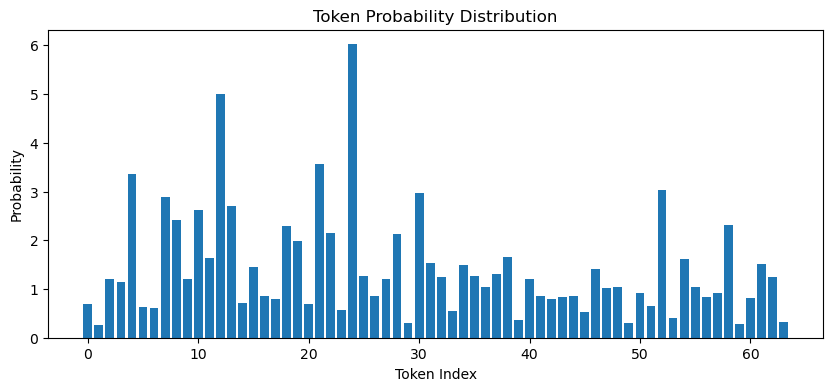

In [117]:
import os 
import torch
# set default device to cuda, raise an error if cuda is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
if not torch.cuda.is_available():
    raise ValueError("CUDA is not available. Please install a CUDA-enabled version of PyTorch.")
torch.set_default_device(device)



torch.set_default_device(device)

# device= 'cuda' if torch.cuda.is_available() else 'cpu'
# torch.set_default_device(device)
# assert device == 'cuda', "This notebook is not optimized for CPU"

config = {
    "learning_rate": 1e-3,
    "eval_interval": 200,
    "num_epochs": 1,
    "H": 16,
    "B": 128,
    "T": 128,
    "C": 256,
    "pitches": 128,
    "feedforward_factor": 3,
    "n_heads": 6,
    "dropout": 0.0,
    "l2_penalty": 0.0,
    "n_layers": 8,
    "git_hash": os.popen("git rev-parse HEAD").read().strip(),
    "a": 16,
    "b": 64,
    "c": 64,
    "d": 32,
    "e": 64,
    "f": 16
}

# initial
for k,v in config.items():
    locals ()[k] = v


import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)


class Head(nn.Module):
    '''One Head of self-attention'''
    def __init__(self, H, cross_attention=False):
        super().__init__()
        self.cross_attention = cross_attention
        self.query = nn.Linear(C, H, bias=False)
        self.key = nn.Linear(C, H, bias=False)
        self.value = nn.Linear(C, H, bias=False)
        # self.output = nn.Linear(H, C, bias=False) # output matrix
        self.register_buffer('tril', torch.tril(torch.ones(T, T)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, cross_attention_sequence=None):
        # Query and Key matrices for the attention mechanism
        # x: 8 tokens
        # Q: 16 tall (arbitrary), 32 long channels
        # K: 16 tall (arbitrary), 32 long channels

        query_vectors = self.query(x)

        if self.cross_attention == True:
            key_vectors = self.key(cross_attention_sequence)
            assert key_vectors.shape[-2] == T, "cross_attention_sequence must be the same length as the input sequence"
            value_vectors = self.value(cross_attention_sequence)
        else:
            key_vectors = self.key(x)
            value_vectors = self.value(x)


        # Attention masking(so we can't look into the past):

        if self.cross_attention == False:
            tril = self.tril
            wei = torch.zeros(T, T) 
            wei = wei.masked_fill(tril == 0, float('-inf')) # set the upper triangular to -inf

        # multiply the two to get the attention weights
        attention_pattern = query_vectors @ key_vectors.transpose(-2, -1) # T, T
        attention_pattern = attention_pattern / (H ** 0.5) # scale the attention pattern for numerical stability

        if self.cross_attention == False: # we are doing self-attention, causal masking
            attention_weights = F.softmax(attention_pattern + wei, dim=-1) # T, T (the row dimension is the query)
        else:
            # we are doing cross attention, so we don't need to mask the attention weights
            attention_weights = F.softmax(attention_pattern, dim=-1)

        attention_weights = self.dropout(attention_weights)


        # apply the attention weights to the value vectors
        context = attention_weights @ value_vectors # T, H

        # project back into original space from value space
        # return self.output(context)
        return context

# x = torch.randn(B,T,C)
# x = torch.randn(T,C)
# head_self_attention = Head(H, cross_attention=False)

# print(head_cross_attention(x, x))
# print("="*40)
# print(head_self_attention(x))


class MultiHeadAttention(nn.Module):
    '''Multiple heads of self-attention or cross-attention'''
    def __init__(self, H, C, n_heads, cross_attention=False): # H is head embedding space size, n_heads is number of heads, cross_attention flag
        super().__init__()
        self.heads = nn.ModuleList([Head(H, cross_attention=cross_attention) for _ in range(n_heads)])
        self.combine_heads = nn.Linear(H*n_heads, C)
        self.dropout = nn.Dropout(dropout)
        self.cross_attention = cross_attention

    def forward(self, x, cross_attention_sequence=None):
        if self.cross_attention and cross_attention_sequence is not None:
            x = torch.cat([head(x, cross_attention_sequence) for head in self.heads], dim=-1)
        else:
            x = torch.cat([head(x) for head in self.heads], dim=-1)
        x = self.combine_heads(x)  # T, C
        return self.dropout(x)
    
x = torch.randn(T,C)
multi_head_attention = MultiHeadAttention(H, C, n_heads, cross_attention=True)
# print(multi_head_attention(x, x))


class FeedForward(nn.Module):
    '''Feed-forward neural network'''
    def __init__(self, C):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(C, C * feedforward_factor),
            nn.ReLU(),
            nn.Linear(C * feedforward_factor, C),
            # nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)
    
class LayerNorm(nn.Module):
    '''Layer normalization'''
    def __init__(self, C, use_affine=True):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(C)) if use_affine else None
        self.beta = nn.Parameter(torch.zeros(C)) if use_affine else None

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        if self.gamma is not None and self.beta is not None:
            return self.gamma * (x - mean) / (std + 1e-6) + self.beta
        else:
            return (x - mean) / (std + 1e-6)


class EncoderBlock(nn.Module):
    '''Transformer encoder block'''
    def __init__(self, H, C, n_heads):
        super().__init__()
        self.attention = MultiHeadAttention(H, C, n_heads, cross_attention=True)
        self.norm1 = LayerNorm(C)
        self.feedforward = FeedForward(C)
        self.norm2 = LayerNorm(C)

    def forward(self, x):
        x = self.norm1(x + self.attention(x, x))
        x = self.norm2(x + self.feedforward(x))
        return x


x = torch.randn(T,C)

enc = EncoderBlock(H, C, n_heads)

# print(enc(x).shape)
# print(T,C)


class DecoderBlock(nn.Module):
    '''Transformer decoder block'''
    def __init__(self, H, C, n_heads, feedforward_factor):
        super().__init__()
        self.self_attention = MultiHeadAttention(H, C, n_heads)
        self.cross_attention = MultiHeadAttention(H, C, n_heads, cross_attention=True)
        self.feedforward = FeedForward(C)
        self.norm1 = LayerNorm(C)
        self.norm2 = LayerNorm(C)
        self.norm3 = LayerNorm(C)

    def forward(self, x, cross_attention_sequence):
        x = x + self.self_attention(self.norm1(x))
        x = x + self.cross_attention(self.norm2(x), cross_attention_sequence)
        x = x + self.feedforward(self.norm3(x))
        return x
    
x = torch.randn(T,C)
cross_attention_sequence = torch.randn(T,C)

dec = DecoderBlock(H, C, n_heads, feedforward_factor)
dec(x, cross_attention_sequence).shape


class Block(nn.Module):
    '''Transformer block'''
    def __init__(self, H, C, n_heads):
        super().__init__()
        self.attention = MultiHeadAttention(H, C, n_heads)
        self.ff = FeedForward(C)
        self.norm1 = LayerNorm(C, use_affine=True)
        self.norm2 = LayerNorm(C, use_affine=True)

    def forward(self, x):
        x = x + self.attention(self.norm1(x))
        x = x + self.ff(self.norm2(x))
        return x
    


class TimingTransformer(nn.Module):

    # track: 0-31
    # measure: 0-31
    # measuretick: 0-63
    # duration: 0-128
    # pitch: 0-127
    # return torch.tensor([track, measure, measuretick, duration, pitch], dtype=torch.int32)
    def __init__(self, n_layers):
        super().__init__()
        # embedding dimensions (go into model)
        assert a + b + c + d + e + f == C, f"embedding dimensions must sum to C:{C}"
        self.track_embedding_table = nn.Embedding(32+1, a) # one-hot vector of length 32 (because there are 32 possible tracks) -> a. The +1 is for the start token
        self.measure_embedding_table = nn.Embedding(32+1, b) # 32 possible measures, stored in b dimensions 32 -> b
        self.measuretick_embedding_table = nn.Embedding(64+1, c)
        self.duration_embedding_table = nn.Embedding(128+1, d)
        self.pitch_embedding_table = nn.Embedding(128+1, e)
        self.position_embedding_table = nn.Embedding(T, f)  # there are still only T positions, not t+1 because having start token in vocab means 1 less position,
        #                                                   but in the case of the others, just because there is a start token doesn't mean there is one less, say pitch.
        # start token is: [32, 32, 64, 128, 128]



        # model
        self.encoderlayers = nn.ModuleList([EncoderBlock(H, C, n_heads) for _ in range(n_layers)])
        self.decoderlayers = nn.ModuleList([DecoderBlock(H, C, n_heads, feedforward_factor) for _ in range(n_layers)])

        # de-embedding dimensions (go out of model)
        # Output scheme: a:b track, b:c measure, c:d measuretick, d:e duration, e:f pitch, f:g position
        # it doesn't really matter because we just try and minimize log-likelyhood of the target for each token

        # first 8 dimensions are track, so we want to predict the next track, which is a distribution over the 32 tracks, so output is 32
        # 8 -> 32
        self.track_head = nn.Linear(a, 32) # no +1 because we would never predict the padding token
        # next 32 dimensions are measure, so we want to predict the next measure, which is a distribution over the 32 measures, so output is 32
        # 32 -> 32
        self.measure_head = nn.Linear(b, 32)
        self.measuretick_head = nn.Linear(c, 64)
        self.duration_head = nn.Linear(d, 128)
        self.pitch_head = nn.Linear(e, 128)
        self.position_head = nn.Linear(f, T) # last f dimensions are position, so we want to predict the next position, which is a distribution over the T positions, so output is T



        # LEGACY GPT REFERENCE CODE
        # self.token_embedding_table = nn.Embedding(vocab_size, C) # REMOVE
        # self.position_embedding_table = nn.Embedding(T, C) # REMOVE

        # self.lm_head = nn.Linear(C, vocab_size) # REMOVE
        # self.layers = nn.ModuleList([Block(H, C, n_heads) for _ in range(n_layers)])
        # self.block = nn.ModuleList([Block(H, C, n_heads)])
    
    def encode(self, idx):
        B, T, C = idx.shape # idx is a list of the indices of the tokens, without batch it would be:
        # [track, measure, measuretick, duration, pitch], [track, measure, measuretick, duration, pitch], ...
        # Channel for a given token is whether we are looking at track, measure, measuretick, duration, or pitch

        tracks = idx[:, :, 0]
        measures = idx[:, :, 1]
        measureticks = idx[:, :, 2]
        durations = idx[:, :, 3]
        pitches = idx[:, :, 4]


        # assert tracks is within 0-32, measures is within 0-32, measureticks is within 0-64, durations is within 0-128, pitches is within 0-128
        if not ((tracks >= 0).all() and (tracks <= 32).all()):
            print(f"tracks out of range: {tracks[(tracks < 0) | (tracks > 32)]}")
        if not ((measures >= 0).all() and (measures <= 32).all()):
            print(f"measures out of range: {measures[(measures < 0) | (measures > 32)]}")
        if not ((measureticks >= 0).all() and (measureticks <= 64).all()):
            print(f"measureticks out of range: {measureticks[(measureticks < 0) | (measureticks > 64)]}")
        if not ((durations >= 0).all() and (durations <= 128).all()):
            print(f"durations out of range: {durations[(durations < 0) | (durations > 128)]}")
        if not ((pitches >= 0).all() and (pitches <= 128).all()):
            print(f"pitches out of range: {pitches[(pitches < 0) | (pitches > 128)]}")
        assert (tracks >= 0).all() and (tracks <= 32).all(), f"tracks must be within 0-32"
        assert (measures >= 0).all() and (measures <= 32).all(), f"measures must be within 0-32"
        assert (measureticks >= 0).all() and (measureticks <= 64).all(), f"measureticks must be within 0-64"
        assert (durations >= 0).all() and (durations <= 128).all(), f"durations must be within 0-128"
        assert (pitches >= 0).all() and (pitches <= 128).all(), f"pitches must be within 0-128"

        track_emb = self.track_embedding_table(tracks)
        measure_emb = self.measure_embedding_table(measures)
        measuretick_emb = self.measuretick_embedding_table(measureticks)
        duration_emb = self.duration_embedding_table(durations)
        pitch_emb = self.pitch_embedding_table(pitches)


        position_sequence = self.position_embedding_table(torch.arange(T)).unsqueeze(0) # list of position embeddings, with a batch dimension, but only 1 batch
        pos_emb = position_sequence.repeat(B, 1, 1) # repeat across the batch dimension

        assert track_emb.shape == (B, T, a), f"track_emb shape is {track_emb.shape}"
        assert measure_emb.shape == (B, T, b), f"measure_emb shape is {measure_emb.shape}"
        assert measuretick_emb.shape == (B, T, c), f"measuretick_emb shape is {measuretick_emb.shape}"
        assert duration_emb.shape == (B, T, d), f"duration_emb shape is {duration_emb.shape}"
        assert pitch_emb.shape == (B, T, e), f"pitch_emb shape is {pitch_emb.shape}"
        assert pos_emb.shape == (B, T, f), f"pos_emb shape is {pos_emb.shape}"


        return torch.cat((track_emb, measure_emb, measuretick_emb, duration_emb, pitch_emb, pos_emb), dim=-1)


    def decode(self, latent_dimension):
        a_start, a_end = 0, a
        b_start, b_end = a_end, a_end + b
        c_start, c_end = b_end, b_end + c
        d_start, d_end = c_end, c_end + d
        e_start, e_end = d_end, d_end + e
        f_start, f_end = e_end, e_end + f

        track_emb = latent_dimension[:,:,a_start:a_end]
        measure_emb = latent_dimension[:,:,b_start:b_end]
        measuretick_emb = latent_dimension[:,:,c_start:c_end]
        duration_emb = latent_dimension[:,:,d_start:d_end]
        pitch_emb = latent_dimension[:,:,e_start:e_end]

        # input representation: [track, measure, measuretick, duration, pitch, pos] (all idx's)

        track_dist = self.track_head(track_emb)
        measure_dist = self.measure_head(measure_emb)
        measuretick_dist = self.measuretick_head(measuretick_emb)
        duration_dist = self.duration_head(duration_emb)
        pitch_dist = self.pitch_head(pitch_emb)

        return track_dist, measure_dist, measuretick_dist, duration_dist, pitch_dist



    
    def forward(self, autoregressive_sequence, full_encoder_sequence, targets=None):
    
        b, t, c = full_encoder_sequence.shape

        encoder_sequence = self.encode(full_encoder_sequence)

        decoder_sequence = self.encode(autoregressive_sequence)

        for encoderlayer in self.encoderlayers:
            encoder_sequence = encoderlayer(encoder_sequence)

        for decoderlayer in self.decoderlayers:
            decoder_sequence = decoderlayer(decoder_sequence, encoder_sequence)

        # decode the output
        track_dist, measure_dist, measuretick_dist, duration_dist, pitch_dist = self.decode(decoder_sequence)

        if targets is None:
            return track_dist, measure_dist, measuretick_dist, duration_dist, pitch_dist, None

        track_targets = targets[:, :, 0]
        measure_targets = targets[:, :, 1]
        measuretick_targets = targets[:, :, 2]
        duration_targets = targets[:, :, 3]
        pitch_targets = targets[:, :, 4]

        track_loss = F.cross_entropy(track_dist.view(b*t, 32), track_targets.view(b*t))
        measure_loss = F.cross_entropy(measure_dist.view(b*t, 32), measure_targets.view(b*t))
        measuretick_loss = F.cross_entropy(measuretick_dist.view(b*t, 64), measuretick_targets.view(b*t))
        duration_loss = F.cross_entropy(duration_dist.view(b*t, 128), duration_targets.view(b*t))
        pitch_loss = F.cross_entropy(pitch_dist.view(b*t, 128), pitch_targets.view(b*t))

        total_loss = measuretick_loss + measure_loss + track_loss + duration_loss + pitch_loss

        return track_dist, measure_dist, measuretick_dist, duration_dist, pitch_dist, total_loss




        # for _ in range(max_new_tokens):
        #     logits, loss = self(idx[:,-T:])
        #     # get the predictions of the last token
        #     last_token_logits = logits[:, -1, :] / temperature # all batches, last token, all probabilities
        #     # softmax to get probabilities
        #     probabilities = F.softmax(last_token_logits, dim=-1)
        #     # sample from the probabilities
        #     next_token = torch.multinomial(probabilities, num_samples=1)
        #     # add the new token to the idx tensor
        #     idx = torch.cat((idx, next_token), dim=1)
        # return idx
    


model = TimingTransformer(n_layers)
# load the model weights
# model.load_state_dict(torch.load('model.pth', map_location=device))


# logits, loss = model(xb, yb)
# track_dist, measure Usually there is no benefit to enforcing causality for tasks other than autoregressive generation. Non-causal connectivity is strictly more powerful. shape: {track_dist.shape}")
# print(f"measure dist shape: {measure_dist.shape}")
# print(f"measuretick dist shape: {measuretick_dist.shape}")
# print(f"duration dist shape: {duration_dist.shape}")
# print(f"pitch dist shape: {pitch_dist.shape}")
# print(f"loss: {loss}")


# forward pass


targets = song_dataset[0]["labels"]
autoregressive_sequence = song_dataset[0]["autoregressive_sequence"]
encoder_sequence = song_dataset[0]["perturbed_notes"]

encoder_sequence = encoder_sequence.unsqueeze(0)
autoregressive_sequence = autoregressive_sequence.unsqueeze(0)


token_idx = 6

ablate_idx = token_idx + 1
# ablate the autoregressive sequence, replacing tokens at ablate_idx and beyond with [32, 32, 64, 128, 128]
ablated_autoregressive_sequence = autoregressive_sequence.clone()
ablated_autoregressive_sequence[0, ablate_idx:] = torch.tensor([32, 32, 64, 128, 128], dtype=torch.int64)




# track_dist, measure_dist, measuretick_dist, duration_dist, pitch_dist, loss = model.forward(autoregressive_sequence=autoregressive_sequence, full_encoder_sequence=encoder_sequence)
track_dist, measure_dist, measuretick_dist, duration_dist, pitch_dist, loss = model.forward(autoregressive_sequence=ablated_autoregressive_sequence, full_encoder_sequence=encoder_sequence, targets=targets.unsqueeze(0))
print(f"loss: {loss}")


import matplotlib.pyplot as plt


def get_channel_index_from_name(name):
    if name == 'track':
        return 0
    if name == 'measure':
        return 1
    if name == 'measuretick':
        return 2
    if name == 'duration':
        return 3
    if name == 'pitch':
        return 4


channel_name = 'measuretick'
channel_index = get_channel_index_from_name(channel_name)

second_token_dist = measuretick_dist[0][token_idx]


token_measuretick_idx_label = targets[token_idx][channel_index].item()

print("correct note:", token_measuretick_idx_label)

incorrect_measuretick = encoder_sequence[0][token_idx]
print("noisy note that the model got:", incorrect_measuretick[channel_index].item())

print("model note:", torch.argmax(second_token_dist).item())

print("ablated sequence:", ablated_autoregressive_sequence[0][:10])



# convert from logprobs to probs
# Convert from log probabilities to probabilities
probs = torch.exp(second_token_dist)

# Plot the probabilities
plt.figure(figsize=(10, 4))
plt.bar(range(len(probs)), probs.cpu().detach().numpy())
plt.xlabel('Token Index')
plt.ylabel('Probability')
plt.title('Token Probability Distribution')
plt.show()


In [118]:
# count the # of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 8,736,496 trainable parameters


In [113]:
len(song_dataset)

522073

training

In [119]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

import torch
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

# assuming `song_dataset` is already created
generator = torch.Generator(device=device)

# Define the split ratio
train_ratio = 0.9
train_size = int(train_ratio * len(song_dataset))
val_size = len(song_dataset) - train_size

# split the dataset
train_dataset, val_dataset = random_split(song_dataset, [train_size, val_size], generator=generator)
batch_size=B

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, generator=generator)

@torch.no_grad()
def estimate_loss(num_samples=None):
    model.eval()
    losses = {'train': 0, 'val': 0}
    for split, dataloader in [('train', train_dataloader), ('val', val_dataloader)]:
        total_loss = 0
        num_batches = len(dataloader)
        
        if num_samples is not None:
            num_batches = max(min(num_batches, num_samples // dataloader.batch_size), 1)
        
        for i, batch in enumerate(dataloader):
            if num_samples is not None and i >= num_batches:
                break
            autoregressive_sequence = batch['autoregressive_sequence']
            targets = batch['labels']
            encoder_sequence = batch['perturbed_notes']
            inputs = autoregressive_sequence
            _, _, _, _, _, loss = model(
                autoregressive_sequence=autoregressive_sequence, 
                full_encoder_sequence=encoder_sequence,
                targets=targets
            )
            total_loss += loss.item()
        
        avg_loss = total_loss / num_batches
        losses[split] = avg_loss
    model.train()
    return losses

print(estimate_loss(num_samples = 50))


# set the model to training mode
model.train()

# define the number of epochs for training
num_epochs = config['num_epochs']
eval_interval = config['eval_interval']

# training loop
for epoch in range(num_epochs):
    total_loss = 0
    for i, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        # dict_keys(['notes', 'perturbed_notes', 'time_per_tick', 'autoregressive_sequence', 'labels'])
        autoregressive_sequence = batch['autoregressive_sequence']
        targets = batch['labels']
        encoder_sequence = batch['perturbed_notes']
        # zero the gradients
        optimizer.zero_grad()

        # forward pass: compute the model output
        _, _, _, _, _, loss = model(
            autoregressive_sequence=autoregressive_sequence, 
            full_encoder_sequence=encoder_sequence,
            targets=targets
        )

        # backward pass: compute the gradient of the loss with respect to model parameters
        loss.backward()

        # update the model parameters
        optimizer.step()

        # accumulate the loss
        total_loss += loss.item()
        if i % eval_interval == 0 and i > 0:
            eval_loss = estimate_loss(num_samples=50)
            print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {eval_loss['val']}, Training Loss: {eval_loss['train']}")

    # compute the average loss for the epoch
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_loss}")


# save the model after training
torch.save(model.state_dict(), 'model.pth')

{'train': 22.127466201782227, 'val': 22.098102569580078}


Epoch 1/1:   5%|▌         | 201/3671 [04:53<2:57:58,  3.08s/it]

Epoch 1/1, Validation Loss: 8.438929557800293, Training Loss: 8.366434097290039


Epoch 1/1:   7%|▋         | 246/3671 [05:58<1:21:15,  1.42s/it]

In [44]:
torch.save(model.state_dict(), 'model.pth')

inference

In [55]:
import torch
# set default device to cuda, raise an error if cuda is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
if not torch.cuda.is_available():
    raise ValueError("CUDA is not available. Please install a CUDA-enabled version of PyTorch.")
torch.set_default_device(device)



print(device)
torch.set_default_device(device)
# load model.pth
model.load_state_dict(torch.load('model.pth', map_location=device))

# Move the model to the GPU
model.to(device)
model.eval()

print(model.track_embedding_table.weight.device)

cuda
cuda:0


In [56]:
import torch
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

# assuming `song_dataset` is already created
generator = torch.Generator(device=device)

# Define the split ratio
train_ratio = 0.9
train_size = int(train_ratio * len(song_dataset))
val_size = len(song_dataset) - train_size

# split the dataset
train_dataset, val_dataset = random_split(song_dataset, [train_size, val_size], generator=generator)
batch_size=B

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, generator=generator)



In [7]:
# estimate_loss(num_samples = 50)

In [101]:
def pad_sequence(sequence):
    desired_sequence_length = T
    # ensure the sequence does not have a batch dimension (it is 2 dimensional)
    assert len(sequence.shape) == 2, f"Sequence has {len(sequence.shape)} dimensions, but 2 are expected"

    sequence_length = sequence.shape[-2]  # 2nd dimension from the right, aka time dimension

    if sequence_length < desired_sequence_length:
        # pad to be the desired sequence length
        pad_tensor = torch.tensor([[32, 32, 64, 128, 128]], dtype=torch.int64)
        while len(sequence) < desired_sequence_length:
            sequence = torch.cat((sequence, pad_tensor), dim=0)

    return sequence

def predict_next_token(autoregressive_seq, encoder_sequence):
    desired_sequence_length = T
    prediction_idx = autoregressive_seq.shape[-2]

    autoregressive_seq = pad_sequence(autoregressive_seq)
    autoregressive_seq = autoregressive_seq.unsqueeze(0)
    encoder_sequence = encoder_sequence.unsqueeze(0)

    # run a forward pass
    track_dist, measure_dist, measuretick_dist, duration_dist, pitch_dist, loss = model(
        autoregressive_sequence=autoregressive_seq,
        full_encoder_sequence=encoder_sequence
    )

    predicted_track = torch.argmax(track_dist[0][prediction_idx]).item()
    predicted_measure = torch.argmax(measure_dist[0][prediction_idx]).item()
    predicted_measuretick = torch.argmax(measuretick_dist[0][prediction_idx]).item()
    predicted_duration = torch.argmax(duration_dist[0][prediction_idx]).item()
    predicted_pitch = torch.argmax(pitch_dist[0][prediction_idx]).item()

    return torch.tensor([predicted_track, predicted_measure, predicted_measuretick, predicted_duration, predicted_pitch], dtype=torch.int64)

# Example usage
# autoregressive_seq = torch.tensor([[32, 32, 64, 128, 128]], dtype=torch.int64)

# generated_token = predict_next_token(autoregressive_seq, encoder_sequence)
# print(f"Generated token: {generated_token}")

def generate_n_tokens(encoder_sequence, n):
    autoregressive_seq = torch.tensor([[32, 32, 64, 128, 128]], dtype=torch.int64)
    for _ in range(n):
        generated_token = predict_next_token(autoregressive_seq, pad_sequence(encoder_sequence))
        autoregressive_seq = torch.cat((autoregressive_seq, generated_token.unsqueeze(0)), dim=0)

    return autoregressive_seq


def correct_sequence_timing(noisy_sequence):
    generated_sequence = generate_n_tokens(noisy_sequence, 127)
    # remove the start token
    generated_sequence = generated_sequence[1:]
    return generated_sequence



# Example usage
# song_data = song_dataset[0]
# encoder_sequence = song_data["perturbed_notes"]
# generated_sequence = generate_n_tokens(encoder_sequence, 15)

# print(generated_sequence[1:])

# original_sequence = song_data["notes"]
# print("original sequence:")
# print(original_sequence[:14])

song_data = song_dataset[0]
encoder_sequence = song_data["perturbed_notes"]
time_per_tick = song_data["time_per_tick"]
clean_sequence = correct_sequence_timing(encoder_sequence)

print("cleaned sequence:")
print(clean_sequence[:14])

print("original sequence")
print(song_data["notes"][:14])

cleaned sequence:
tensor([[  1,   0,   0, 127,  67],
        [  2,   0,   0, 127,  59],
        [  3,   0,   0, 127,  50],
        [  4,   0,   0, 127,  43],
        [  0,   0,  16,  16,  74],
        [  0,   0,   0,  32,  50],
        [  0,   0,   0,  16,  71],
        [  0,   1,   0,  16,  74],
        [  0,   1,  16,  32,  71],
        [  0,   1,  48,  16,  67],
        [  0,   2,   0,  16,  69],
        [  2,   2,   0,  32,  57],
        [  3,   2,   0,  32,  50],
        [  0,   2,  16,  16,  69]], device='cuda:0')
original sequence
tensor([[  0,   0,   0,  16,  71],
        [  1,   0,   0, 127,  67],
        [  2,   0,   0, 127,  59],
        [  3,   0,   0, 127,  50],
        [  4,   0,   0, 127,  43],
        [  0,   0,  16,  16,  74],
        [  0,   0,  32,  24,  74],
        [  0,   0,  56,   8,  76],
        [  0,   1,   0,  16,  74],
        [  0,   1,  16,  32,  71],
        [  0,   1,  48,  16,  67],
        [  0,   2,   0,  16,  69],
        [  2,   2,   0,  32,  57],
 

In [85]:
# convert the sequence to a list of notes if format, [track, start, duration, pitch]
def sequence_to_notes(sequence):
    notes = []
    for i, token in enumerate(sequence):
        track, measure, measuretick, duration, pitch = token
        start = (measure * 64) + measuretick
        duration = duration
        pitch = pitch
        notes.append([track, start, duration, pitch])
    return notes

cleaned_notes = torch.tensor(sequence_to_notes(clean_sequence))
dirty_notes = torch.tensor(sequence_to_notes(encoder_sequence))

In [91]:
import pretty_midi
import torch

def tensor_to_midi(tensor, output_filename, time_per_tick):
    """
    Converts a tensor representation of a song back to a MIDI file.

    Parameters:
    - tensor: torch.Tensor, the quantized notes tensor of the song.
    - output_filename: str, the filename for the output MIDI file.
    """
    # Create a PrettyMIDI object
    midi = pretty_midi.PrettyMIDI()

    # Get unique track numbers
    track_numbers = tensor[:, 0].unique().numpy()

    for track_number in track_numbers:
        # Create an Instrument instance for each track
        instrument = pretty_midi.Instrument(program=0)  # Default to Acoustic Grand Piano

        # Filter notes for the current track
        track_notes = tensor[tensor[:, 0] == track_number]

        # Extract start times, durations, and pitches
        start_times = track_notes[:, 1].numpy()
        durations = track_notes[:, 2].numpy()
        pitches = track_notes[:, 3].numpy()

        # Create Note objects and add them to the instrument
        for start, duration, pitch in zip(start_times, durations, pitches):
            note = pretty_midi.Note(
                velocity=100,  # Default velocity
                pitch=int(pitch),
                start=(start*time_per_tick).item(),
                end=((start + duration)*time_per_tick).item()
            )
            instrument.notes.append(note)

        # Add the instrument to the PrettyMIDI object
        midi.instruments.append(instrument)

    # Write out the MIDI data
    midi.write(output_filename)

# Example usage




# song_example = song_dataset[1]  # Get the first song tensor
# notes = song_example["notes"]
# perturbed_notes = song_example["perturbed_notes"]
# time_per_tick = song_example["time_per_tick"]
time_per_tick = time_per_tick
notes = cleaned_notes


tensor_to_midi(notes.cpu(), 'output_song.mid', time_per_tick)

In [92]:
import pygame

def play_midi_file(midi_filename):
    """
    Plays a MIDI file using pygame.

    Parameters:
    - midi_filename: str, the filename of the MIDI file to play.
    """
    # Initialize pygame
    pygame.init()

    # Set up the mixer to play MIDI
    pygame.mixer.init()
    pygame.mixer.music.load(midi_filename)

    # Play the MIDI file
    pygame.mixer.music.play()

    # Keep the program running until the music stops
    while pygame.mixer.music.get_busy():
        pygame.time.Clock().tick(10)

# Example usage
midi_filename = 'output_song.mid'
play_midi_file(midi_filename)

KeyboardInterrupt: 